In [1]:
# Install required packages
!pip install torch torchvision torchaudio
!pip install matplotlib opencv-python scikit-image pillow numpy

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage import io, img_as_float
import random
import os
from google.colab import files
import io as python_io

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✅ All dependencies installed successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎯 Current device: {torch.cuda.get_device_name()}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 836.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [7]:
class UNet(nn.Module):
    """U-Net architecture for Noise2Void denoising"""

    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (downsampling)
        in_ch = in_channels
        for feature in features:
            self.encoder.append(self._double_conv(in_ch, feature))
            in_ch = feature

        # Bottleneck
        self.bottleneck = self._double_conv(features[-1], features[-1] * 2)

        # Decoder (upsampling)
        for feature in reversed(features):
            self.decoder.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(self._double_conv(feature * 2, feature))

        # Final layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip_connections = []

        # Encoder
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](concat_skip)

        return self.final_conv(x)

print("✅ U-Net model architecture defined successfully!")

✅ U-Net model architecture defined successfully!


In [8]:
class Noise2VoidDataset(Dataset):
    """Dataset class for Noise2Void training"""

    def __init__(self, image, patch_size=64, n_patches=1000):
        self.image = image
        self.patch_size = patch_size
        self.n_patches = n_patches
        self.h, self.w = image.shape[:2]

    def __len__(self):
        return self.n_patches

    def __getitem__(self, idx):
        # Random crop
        top = np.random.randint(0, max(1, self.h - self.patch_size))
        left = np.random.randint(0, max(1, self.w - self.patch_size))

        if len(self.image.shape) == 3:
            patch = self.image[top:top+self.patch_size, left:left+self.patch_size, :]
        else:
            patch = self.image[top:top+self.patch_size, left:left+self.patch_size]

        # Ensure patch is the right size
        if patch.shape[0] < self.patch_size or patch.shape[1] < self.patch_size:
            if len(self.image.shape) == 3:
                patch = np.pad(patch, ((0, max(0, self.patch_size - patch.shape[0])),
                                     (0, max(0, self.patch_size - patch.shape[1])), (0, 0)), 'reflect')
            else:
                patch = np.pad(patch, ((0, max(0, self.patch_size - patch.shape[0])),
                                     (0, max(0, self.patch_size - patch.shape[1]))), 'reflect')

        # Convert to tensor and add channel dimension if needed
        if len(patch.shape) == 2:
            patch = patch[np.newaxis, ...]  # Add channel dimension
        else:
            patch = patch.transpose(2, 0, 1)  # CHW format

        input_patch = torch.FloatTensor(patch.copy())
        target_patch = torch.FloatTensor(patch.copy())

        # Noise2Void masking strategy
        mask = self.get_stratified_coords(target_patch.shape[-2:], box_size=4)

        for coords in mask:
            y, x = coords
            # Replace pixel with random neighbor
            neighbors = []
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < patch.shape[-2] and 0 <= nx < patch.shape[-1] and (dy != 0 or dx != 0):
                        neighbors.append((ny, nx))

            if neighbors:
                ny, nx = random.choice(neighbors)
                input_patch[:, y, x] = input_patch[:, ny, nx]

        return input_patch, target_patch, torch.tensor(mask)

    def get_stratified_coords(self, patch_shape, box_size):
        """Get stratified coordinates for masking"""
        h, w = patch_shape
        box_count_y = int(np.ceil(h / box_size))
        box_count_x = int(np.ceil(w / box_size))
        coords = []

        for i in range(box_count_y):
            for j in range(box_count_x):
                y_start = i * box_size
                x_start = j * box_size
                y_end = min((i + 1) * box_size, h)
                x_end = min((j + 1) * box_size, w)

                if y_end > y_start and x_end > x_start:
                    y = np.random.randint(y_start, y_end)
                    x = np.random.randint(x_start, x_end)
                    coords.append([y, x])

        return coords

print("✅ Noise2Void dataset class defined successfully!")

✅ Noise2Void dataset class defined successfully!


📁 Please upload your noisy image...


Saving rgb4_noise.png to rgb4_noise (1).png
✅ Uploaded file: rgb4_noise (1).png
🔄 Converting to grayscale...
📊 Image shape: (512, 512)
📊 Image range: [0.012, 0.631]


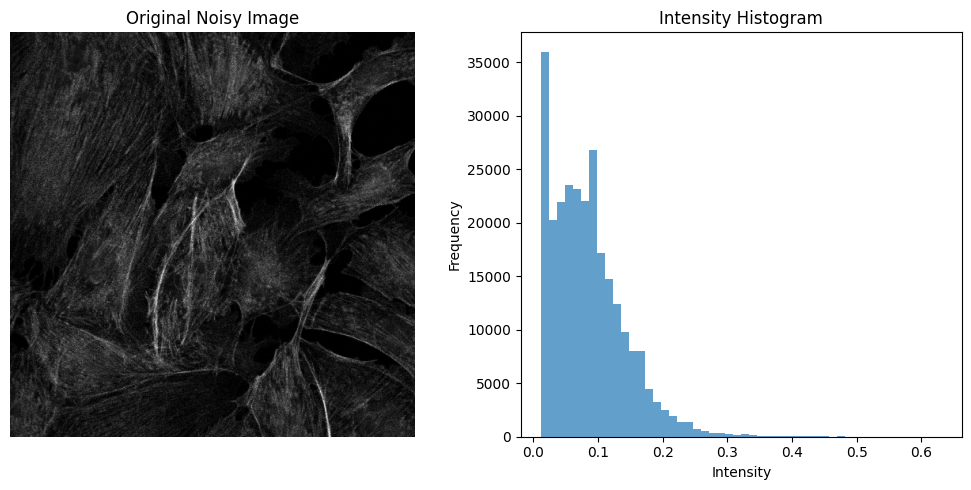

In [9]:
def upload_and_preprocess_image():
    """Upload and preprocess the noisy image"""
    print("📁 Please upload your noisy image...")
    uploaded = files.upload()

    filename = list(uploaded.keys())[0]
    print(f"✅ Uploaded file: {filename}")

    # Load and preprocess the image
    image = Image.open(python_io.BytesIO(uploaded[filename]))

    # Convert to grayscale if needed (Noise2Void typically works on single channel)
    if image.mode != 'L':
        print("🔄 Converting to grayscale...")
        image = image.convert('L')

    # Convert to numpy array and normalize
    image_array = np.array(image, dtype=np.float32) / 255.0

    print(f"📊 Image shape: {image_array.shape}")
    print(f"📊 Image range: [{image_array.min():.3f}, {image_array.max():.3f}]")

    # Display original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_array, cmap='gray')
    plt.title('Original Noisy Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.hist(image_array.flatten(), bins=50, alpha=0.7)
    plt.title('Intensity Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    return image_array

# Upload the image
noisy_image = upload_and_preprocess_image()

🏋️ Training Noise2Void model...
🎯 Training on: cuda
🚀 Starting training for 30 epochs...
📊 Epoch [10/30], Loss: 0.222844
📊 Epoch [20/30], Loss: 0.220037
📊 Epoch [30/30], Loss: 0.215832
✅ Training completed!


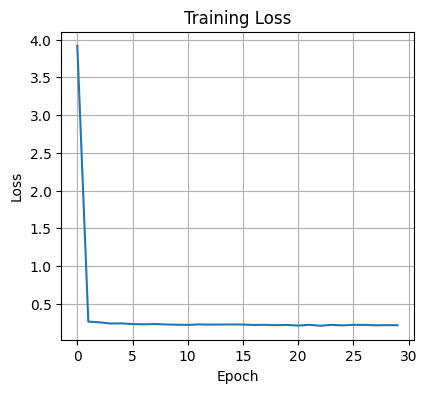

In [10]:
def train_noise2void(image, epochs=50, patch_size=64, n_patches=2000, batch_size=16, learning_rate=1e-3):
    """Train Noise2Void model"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🎯 Training on: {device}")

    # Create dataset and dataloader
    dataset = Noise2VoidDataset(image, patch_size=patch_size, n_patches=n_patches)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Initialize model
    model = UNet(in_channels=1, out_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    model.train()
    losses = []

    print(f"🚀 Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        epoch_loss = 0.0

        for batch_idx, (input_batch, target_batch, mask_batch) in enumerate(dataloader):
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(input_batch)

            # Compute loss only on masked pixels
            loss = 0.0
            for i in range(input_batch.shape[0]):
                mask = mask_batch[i]
                if len(mask) > 0:
                    for coords in mask:
                        y, x = coords
                        if y < output.shape[2] and x < output.shape[3]:
                            loss += criterion(output[i, :, y, x], target_batch[i, :, y, x])

            if loss > 0:
                loss = loss / input_batch.shape[0]  # Average over batch
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"📊 Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    print("✅ Training completed!")

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    return model, losses

# Start training
print("🏋️ Training Noise2Void model...")
model, training_losses = train_noise2void(noisy_image, epochs=30, patch_size=64, n_patches=1500)

🔮 Applying trained model to denoise the image...
🔮 Denoising image using sliding window approach...


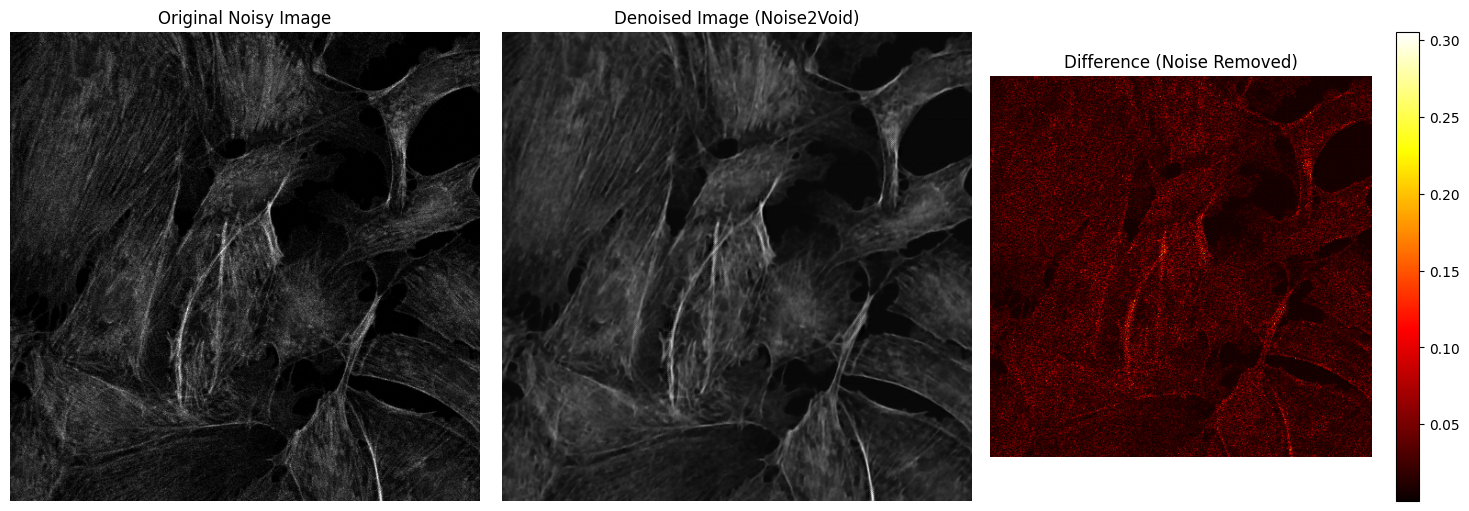

📊 Denoising Results:
   🔸 MSE: 0.000737
   🔸 PSNR: 31.32 dB
   🔸 Noise variance reduction: 0.000939


In [11]:
def denoise_image(model, noisy_image, patch_size=64, overlap=16):
    """Apply trained model to denoise the full image"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    h, w = noisy_image.shape

    # Handle small images
    if h < patch_size or w < patch_size:
        # Process the entire image at once
        if len(noisy_image.shape) == 2:
            input_tensor = torch.FloatTensor(noisy_image[np.newaxis, np.newaxis, ...]).to(device)
        else:
            input_tensor = torch.FloatTensor(noisy_image.transpose(2, 0, 1)[np.newaxis, ...]).to(device)

        with torch.no_grad():
            denoised_tensor = model(input_tensor)
            denoised_image = denoised_tensor.squeeze().cpu().numpy()

        return np.clip(denoised_image, 0, 1)

    # For larger images, use sliding window approach
    step_size = patch_size - overlap
    denoised = np.zeros_like(noisy_image)
    weight_map = np.zeros_like(noisy_image)

    print("🔮 Denoising image using sliding window approach...")

    with torch.no_grad():
        for y in range(0, h - patch_size + 1, step_size):
            for x in range(0, w - patch_size + 1, step_size):
                # Extract patch
                patch = noisy_image[y:y+patch_size, x:x+patch_size]

                # Add batch and channel dimensions
                input_tensor = torch.FloatTensor(patch[np.newaxis, np.newaxis, ...]).to(device)

                # Denoise patch
                denoised_patch = model(input_tensor).squeeze().cpu().numpy()

                # Add to result with weight
                denoised[y:y+patch_size, x:x+patch_size] += denoised_patch
                weight_map[y:y+patch_size, x:x+patch_size] += 1

        # Handle remaining regions
        if h % step_size != 0:
            y = h - patch_size
            for x in range(0, w - patch_size + 1, step_size):
                patch = noisy_image[y:y+patch_size, x:x+patch_size]
                input_tensor = torch.FloatTensor(patch[np.newaxis, np.newaxis, ...]).to(device)
                denoised_patch = model(input_tensor).squeeze().cpu().numpy()
                denoised[y:y+patch_size, x:x+patch_size] += denoised_patch
                weight_map[y:y+patch_size, x:x+patch_size] += 1

        if w % step_size != 0:
            x = w - patch_size
            for y in range(0, h - patch_size + 1, step_size):
                patch = noisy_image[y:y+patch_size, x:x+patch_size]
                input_tensor = torch.FloatTensor(patch[np.newaxis, np.newaxis, ...]).to(device)
                denoised_patch = model(input_tensor).squeeze().cpu().numpy()
                denoised[y:y+patch_size, x:x+patch_size] += denoised_patch
                weight_map[y:y+patch_size, x:x+patch_size] += 1

        # Handle corner
        if h % step_size != 0 and w % step_size != 0:
            y, x = h - patch_size, w - patch_size
            patch = noisy_image[y:y+patch_size, x:x+patch_size]
            input_tensor = torch.FloatTensor(patch[np.newaxis, np.newaxis, ...]).to(device)
            denoised_patch = model(input_tensor).squeeze().cpu().numpy()
            denoised[y:y+patch_size, x:x+patch_size] += denoised_patch
            weight_map[y:y+patch_size, x:x+patch_size] += 1

    # Normalize by weights
    weight_map[weight_map == 0] = 1
    denoised = denoised / weight_map

    return np.clip(denoised, 0, 1)

# Denoise the image
print("🔮 Applying trained model to denoise the image...")
denoised_image = denoise_image(model, noisy_image)

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Original Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image (Noise2Void)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(noisy_image - denoised_image), cmap='hot')
plt.title('Difference (Noise Removed)')
plt.axis('off')
plt.colorbar()

plt.tight_layout()
plt.show()

# Calculate and display metrics
mse = np.mean((noisy_image - denoised_image) ** 2)
psnr = 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else float('inf')

print(f"📊 Denoising Results:")
print(f"   🔸 MSE: {mse:.6f}")
print(f"   🔸 PSNR: {psnr:.2f} dB")
print(f"   🔸 Noise variance reduction: {np.var(noisy_image) - np.var(denoised_image):.6f}")

✅ Results saved:
   📁 denoised_image.png - Denoised image
   📁 noise2void_model.pth - Trained model weights


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

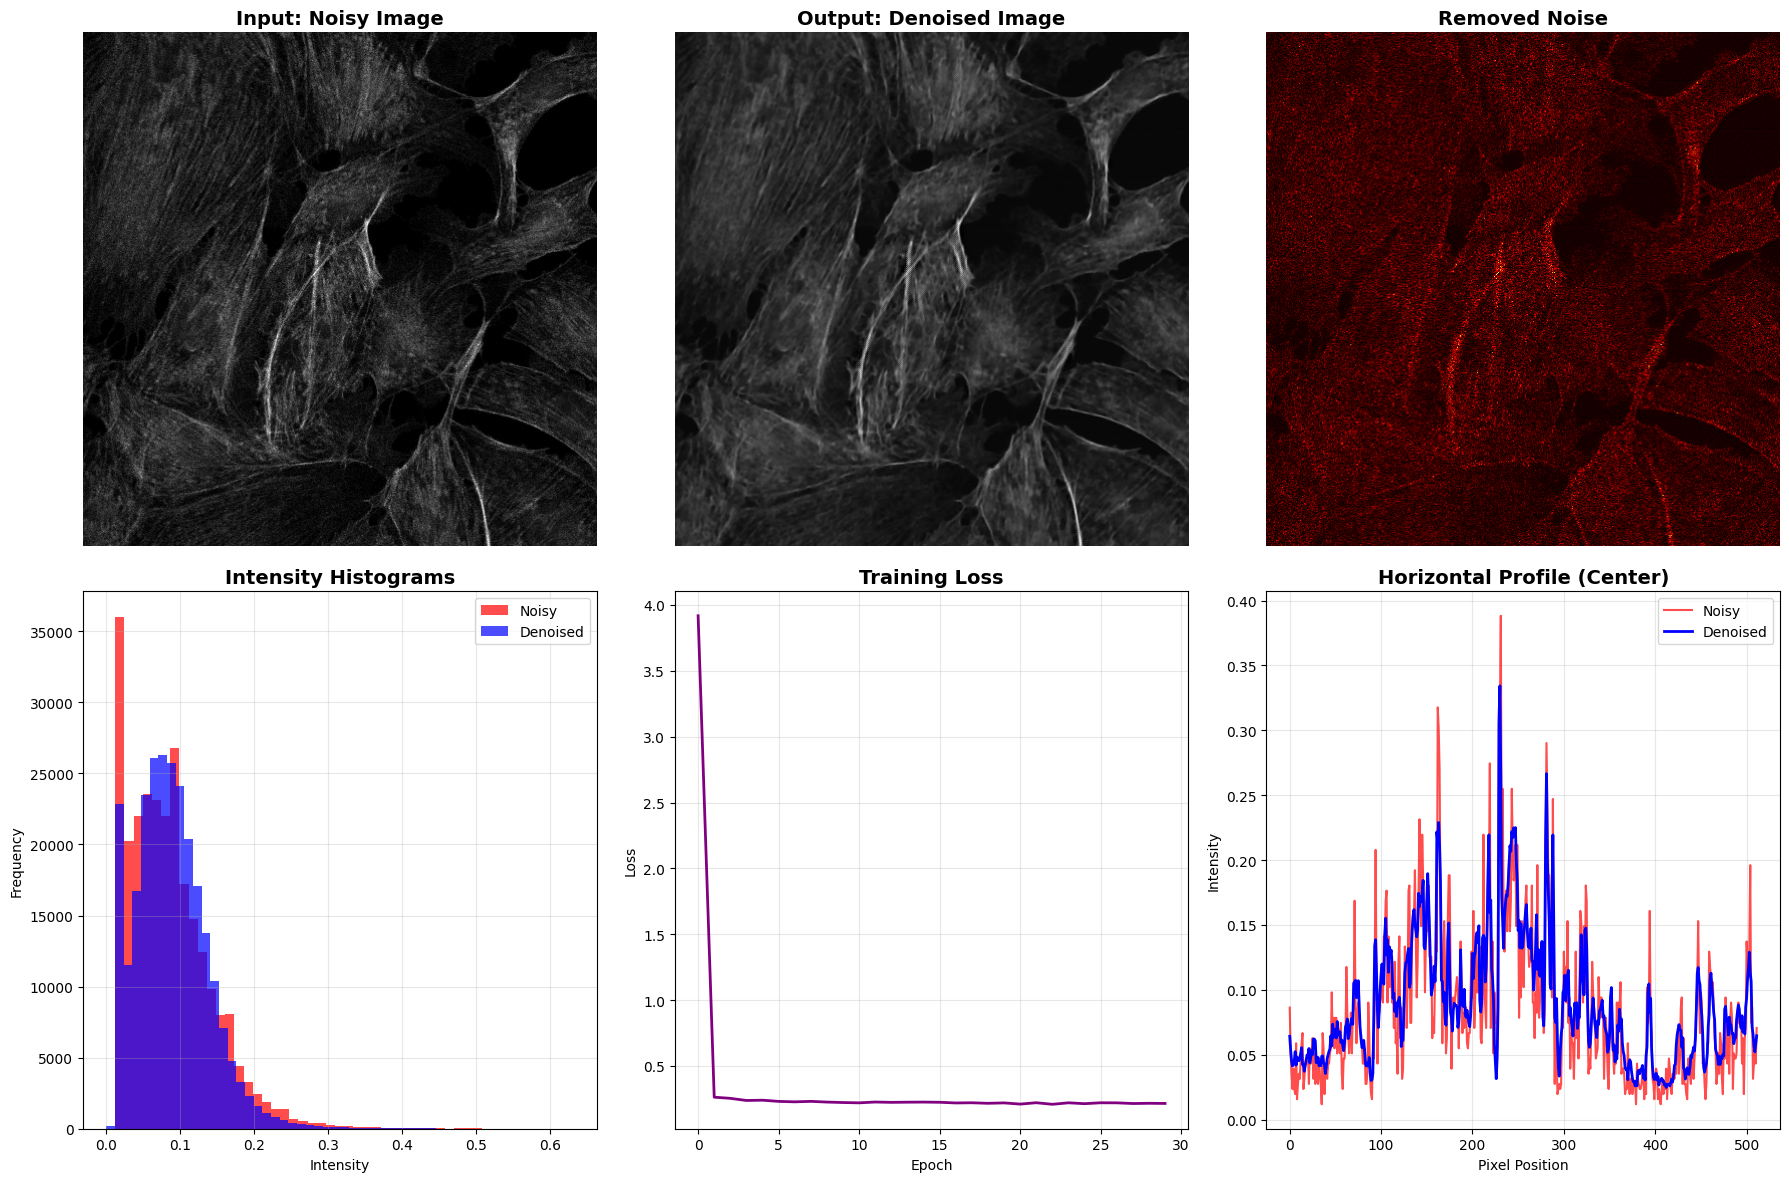


🎉 Noise2Void denoising completed successfully!
📊 Final Metrics:
   🔸 PSNR Improvement: 31.32 dB
   🔸 MSE: 0.000737
   🔸 Noise Variance Reduced: 0.000939


In [12]:
# Save the denoised image
def save_results():
    """Save the denoised image and model"""

    # Convert denoised image back to 0-255 range
    denoised_uint8 = (denoised_image * 255).astype(np.uint8)

    # Save as PNG
    denoised_pil = Image.fromarray(denoised_uint8, mode='L')
    denoised_pil.save('denoised_image.png')

    # Save model
    torch.save(model.state_dict(), 'noise2void_model.pth')

    print("✅ Results saved:")
    print("   📁 denoised_image.png - Denoised image")
    print("   📁 noise2void_model.pth - Trained model weights")

    # Download files
    files.download('denoised_image.png')
    files.download('noise2void_model.pth')

# Save results
save_results()

# Create a comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Images
axes[0, 0].imshow(noisy_image, cmap='gray')
axes[0, 0].set_title('Input: Noisy Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(denoised_image, cmap='gray')
axes[0, 1].set_title('Output: Denoised Image', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(np.abs(noisy_image - denoised_image), cmap='hot')
axes[0, 2].set_title('Removed Noise', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Analysis
axes[1, 0].hist(noisy_image.flatten(), bins=50, alpha=0.7, label='Noisy', color='red')
axes[1, 0].hist(denoised_image.flatten(), bins=50, alpha=0.7, label='Denoised', color='blue')
axes[1, 0].set_title('Intensity Histograms', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Intensity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(training_losses, linewidth=2, color='purple')
axes[1, 1].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True, alpha=0.3)

# Profile comparison
center_x, center_y = noisy_image.shape[1] // 2, noisy_image.shape[0] // 2
profile_noisy = noisy_image[center_y, :]
profile_denoised = denoised_image[center_y, :]

axes[1, 2].plot(profile_noisy, label='Noisy', color='red', alpha=0.7)
axes[1, 2].plot(profile_denoised, label='Denoised', color='blue', linewidth=2)
axes[1, 2].set_title('Horizontal Profile (Center)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Pixel Position')
axes[1, 2].set_ylabel('Intensity')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('noise2void_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🎉 Noise2Void denoising completed successfully!")
print("=" * 50)
print(f"📊 Final Metrics:")
print(f"   🔸 PSNR Improvement: {psnr:.2f} dB")
print(f"   🔸 MSE: {mse:.6f}")
print(f"   🔸 Noise Variance Reduced: {(np.var(noisy_image) - np.var(denoised_image)):.6f}")
print("=" * 50)